In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input


# Gasoline WTI

## 7:3

In [47]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Gasoline RBOB.csv')

In [48]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [49]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-05-31,2.4174,2.3914,2.4331,2.3914,16.83K,0.53%
1,2024-05-30,2.4046,2.4560,2.4613,2.4295,0.44K,-2.43%
2,2024-05-29,2.4644,2.5208,2.5304,2.4579,1.28K,-1.78%
3,2024-05-28,2.5090,2.5151,2.5244,2.5022,0.33K,-0.20%
4,2024-05-27,2.5140,2.5020,2.5154,2.5020,0.02K,1.53%
...,...,...,...,...,...,...,...
1622,2019-03-06,1.5674,1.7604,1.7919,1.7524,91.54K,0.47%
1623,2019-03-05,1.5601,1.7474,1.7735,1.7387,61.43K,0.46%
1624,2019-03-04,1.5530,1.7285,1.7660,1.7285,62.55K,-10.41%
1625,2019-03-03,1.7335,1.7310,1.7420,1.7298,NaN,12.89%


In [50]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [51]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01,1.5356,1.7521,1.7720,1.7124,69010.0,-1.37
1,2019-03-04,1.5530,1.7285,1.7660,1.7285,62550.0,-10.41
2,2019-03-05,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07,1.5743,1.7845,1.8160,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1330,2024-05-27,2.5140,2.5020,2.5154,2.5020,20.0,1.53
1331,2024-05-28,2.5090,2.5151,2.5244,2.5022,330.0,-0.20
1332,2024-05-29,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1333,2024-05-30,2.4046,2.4560,2.4613,2.4295,440.0,-2.43


In [52]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

In [53]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [55]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [56]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [57]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.8969
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7761e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4481e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0909e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3611e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6701e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6916e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2716e-04 
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2951e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4994e-04
Epoch 15/100
21/21 ━━━━━━

In [59]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [60]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06697039030207606
MAPE trên tập test là: 2.098437698827809 %
MAE trên tập test là: 0.051005413431391027


In [61]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [62]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.473818
1920,2.505913
1921,2.537216
1922,2.548600
1923,2.555349
...,...
2004,2.913727
2005,2.914465
2006,2.915171
2007,2.915847


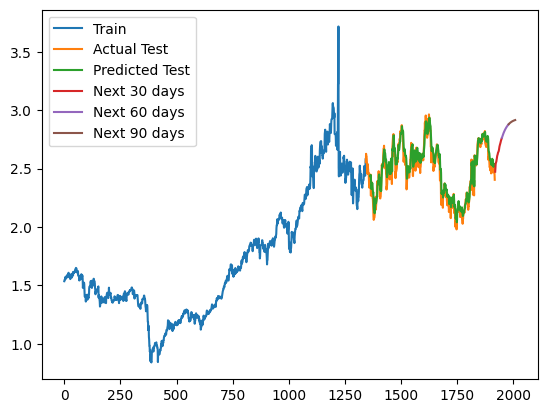

In [63]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RNN_Gasoline_73.png")
plt.legend()
plt.show()

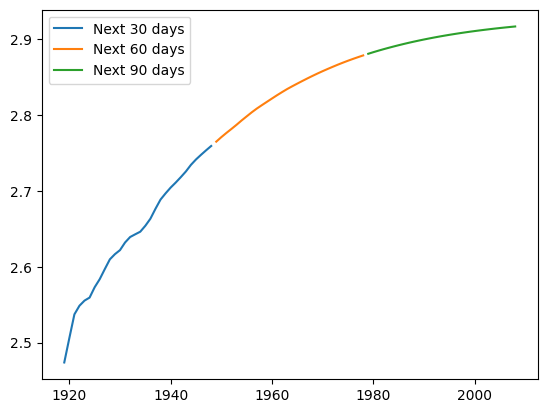

In [64]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]

plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RNN_Gasoline_Predictions.png")
plt.legend()
plt.show()

## 8:2

In [65]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [66]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [67]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [68]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1426
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3117e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0018e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0469e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2608e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1620e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9316e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7935e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0004e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7759e-04
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7188e-04
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9225e-04
Epoch 15/100
24/24 ━━

In [69]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [70]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.04883745752030303
MAPE trên tập test là: 1.3814922748359308 %
MAE trên tập test là: 0.033868056678246515


In [71]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [88]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.435646
1920,2.461748
1921,2.477375
1922,2.486670
1923,2.494061
...,...
2004,2.760391
2005,2.760571
2006,2.760740
2007,2.760898


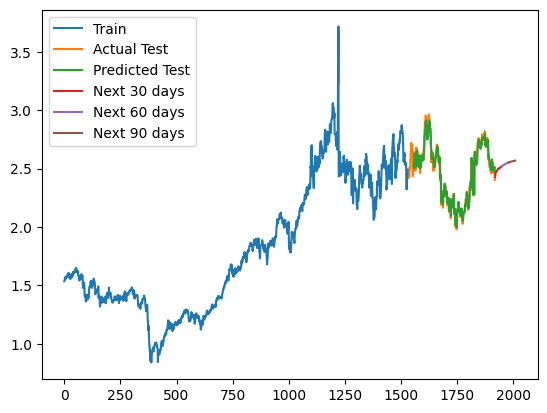

In [79]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RNN_Gasoline_82.png")
plt.legend()
plt.show()

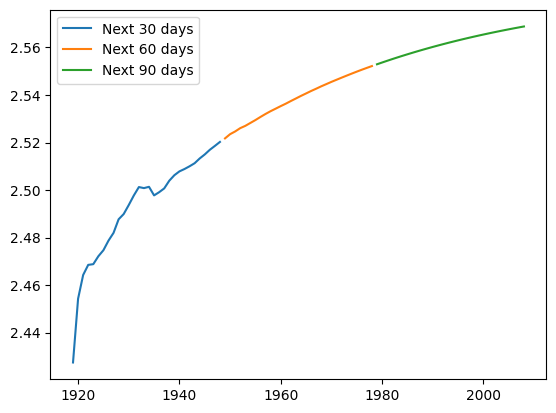

In [80]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]

plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

### 9:1

In [81]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [82]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [83]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [84]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1707
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8613e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2519e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6846e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6351e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4949e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5648e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1848e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5208e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6544e-04
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1930e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2154e-04
Epoch 15/100
27/27 ━━━━━━

In [85]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [86]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.05192592212609362
MAPE trên tập test là: 1.3308372204737695 %
MAE trên tập test là: 0.03201380633303997


In [87]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [89]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.435646
1920,2.461748
1921,2.477375
1922,2.486670
1923,2.494061
...,...
2004,2.760391
2005,2.760571
2006,2.760740
2007,2.760898


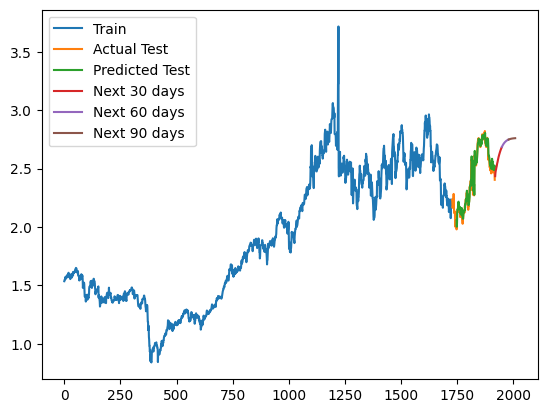

In [90]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RNN_Gasoline_91.png")
plt.legend()
plt.show()

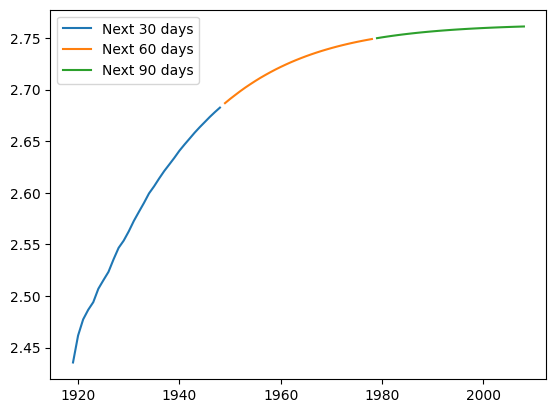

In [91]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]

plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()